# Assignment 3


1. Implement linear regression model for multiclass classification using pytorch.  
1. Implement multinomial and one-vs-rest variants on multiclass classification.
1. Implement L2 relularization for your model.  
1. Test your model on 20newsgroups dataset. Your baseline is accuracy=0.75. 
1. How can we justify using accuracy score for this problem?
1. What is acuraccy score for random answer for this problem?

Follow #TODO in the code below.   
Feel free to add additional regularizers to your model.  
Remember, that SGD convergence is slower that lbfgs from scikit-learn. Manage your time. 


Usefull links:  
1. https://pytorch.org/
1. https://gluon.mxnet.io/chapter06_optimization/gd-sgd-scratch.html
1. (bonus) http://ruder.io/optimizing-gradient-descent/


In [1]:
import torch as tt
from torch.optim import SGD
from torch import nn
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy import sparse
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import normalize
from sklearn.model_selection import GridSearchCV
from math import ceil
import pandas as pd

%matplotlib inline

SEED = 42
np.random.seed(SEED)

#### Базовая предобработка:

In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.externals import joblib

# retrieve dataset
# data = fetch_20newsgroups()

train_data = joblib.load('data/train.data')
test_data = joblib.load('data/test.data')

X_train_data = train_data['data']
y_train = train_data['target']

#TODO some feature engineering
# If you want to use some sparse feature vectors, pay attention to feature size.
# While your feature matrix can be sparse, weight tensor in the model is always dense.

In [3]:
# все возможные классы

np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [16]:
tfidf = TfidfVectorizer(min_df=5, stop_words='english', ngram_range=(1,2))

X_train = tfidf.fit_transform(X_train_data)
X_train.shape, y_train.shape

((11314, 64199), (11314,))

In [17]:
# fetch test subset
# test_data = fetch_20newsgroups(subset='test')

X_test = tfidf.transform(test_data['data'])
y_test = test_data['target']
X_test.shape, y_test.shape

((7532, 64199), (7532,))

In [3]:
class LogisticRegressionNN(nn.Module):
    """
    All neural networks in pytorch are descendants of nn.Module class
    As you remember, Logistic regression is just a 1-layer neural network
    #TODO implement multinomial logistic regression
    """
    
    def __init__(self, d, k):
        """
        In the constructor we define model weights and layers
        d: feature size
        k: number of classes
        """
        super(LogisticRegressionNN, self).__init__()
        
        # TODO create tensor of weights and tensor of biases
        # initialize tensors from N(0,1) using np.random.rand
        # W has shape (d,k)
        # b has shape (d,)
        # set requires_grad=True for tensors, so they can be learned during training
        
        self.W = tt.tensor(np.random.randn(d, k), dtype=tt.float32, requires_grad=True)
        self.b = tt.tensor(np.random.randn(k,), dtype=tt.float32, requires_grad=True)
        
    def forward(self, x):
        """
        In this method we implement connections between neural network weights
        x: batch feature matrix
        returns: probability logits
        """
        # TODO implement linear model without softmax
        result = tt.mm(x, self.W) + self.b
        return result
    
    def parameters(self):
        """
        learnable model parameters
        """
        return [self.W, self.b]
    
    
class LogisticRegressionEstimator(BaseEstimator, ClassifierMixin):
    """
    Logistic Regression estimator coping interface from scikit-learn
    """
    def __init__(self, learning_rate, n_epochs, batch_size, alpha=1,
                 multi_class='multinomial', verbose=False):
        """
        learning_rate: SGD learning rate
        n_epochs: number of epochs
        batch_size: size of mini-batch
        alpha:  regularizer coef
        multi_class: ['multinomial', 'ovr']
        verbose:
        """
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.alpha = alpha
        self.multi_class = multi_class
        self.verbose = verbose
        self.model_nn = None
        self.batch_size = batch_size
        
    def _train_nn(self, model, X, y):
        """
        Train neural network
        model: neural network module
        X: - feature matrix
        y: - target values
        """
        
        # criterion to minimize
        criterion = nn.CrossEntropyLoss()
        # optimization algorithm
        optimizer = tt.optim.SGD(model.parameters(), lr=self.learning_rate)

        #TODO calculate number of batches, round to the ceil
        n_rows = X.shape[0]
        n_batches = ceil(n_rows / self.batch_size)

        if self.verbose:
            t_epochs = tqdm_notebook(range(self.n_epochs), desc='epochs', leave=True)
        else:
            t_epochs = range(self.n_epochs)
        
        # training history
        self.history = []
        
        # iterate over epochs
        for epoch in t_epochs:

            # TODO make random permutation over indices, use np.random.choice
            indices = np.random.choice(n_rows, n_rows, replace=False)
            
            epoch_average_loss = 0

            # iterate over mini-batches
            for j in range(n_batches):

                batch_idx = list(indices[j: j + self.batch_size])

                # we have to wrap data into tensors before feed them to neural network
                #TODO: batch feature float tensor. use tt.from_numpy

                if sparse.issparse(X):
                    # create sparse tensor
                    X_curr = X[batch_idx].tocoo()
                    ii = tt.LongTensor([X_curr.row, X_curr.col])
                    batch_x = tt.sparse.FloatTensor(ii,
                                                    tt.from_numpy(X_curr.data).float(),
                                                    X_curr.shape)
                else:
                    # create dense tensor
                    batch_x = tt.from_numpy(X[batch_idx]).float()

                #TODO batch target long tensor. use tt.from_numpy
                batch_y = tt.from_numpy(y[batch_idx])

                # reset gradients for the new iteration
                optimizer.zero_grad()
                # get predictions
                pred = model.forward(batch_x)
                
                # cross-entropy loss
                loss = criterion(pred, batch_y)
                #TODO: add regularizer on weights
                loss += self.alpha/2 * tt.norm(model.W)**2

                # calculate gradients
                loss.backward()
                # make optimization step
                optimizer.step()

                epoch_average_loss += loss.data.detach().item()

            # average loss for epoch
            epoch_average_loss /= n_batches
            if self.verbose:
                t_epochs.set_postfix(loss='%.3f' % epoch_average_loss)
                
            # logging
            self.history.append((epoch, loss.data[0].detach()))
        
    def fit(self, X, y):
        """
        X: feature matrix
        y: target values
        """
        
        n_features = X.shape[1]
        self.n_classes_ = len(np.unique(y))
        
        # binary classification
        if self.n_classes_ == 2:
            self.model_nn = LogisticRegressionNN(n_features, 2)
            self._train_nn(self.model_nn, X, y)
            
        else:
            
            if self.multi_class == 'multinomial':
                # TODO: multinomial classification
                self.model_nn = LogisticRegressionNN(n_features, self.n_classes_)
                self._train_nn(self.model_nn, X, y)
                
            # ovr classification
            elif self.multi_class == 'ovr':
                
                if self.verbose:
                    t_ovr = tqdm_notebook(range(self.n_classes_), desc='ovr')
                else:
                    t_ovr = range(self.n_classes_)
                
                # TODO: one-vs-rest classification
                self.model_nn = []
                y_classes = np.unique(y)
                
                for i in range(self.n_classes_):
                    y_current = np.array(list(map(lambda x: 1 if x == y_classes[i] else 0, y)))
                    self.model_nn.append(LogisticRegressionNN(n_features, 2))
                    self._train_nn(self.model_nn[i], X, y_current)   
                    
        return self
                    
    def predict_proba(self, X):
        
        if sparse.issparse(X):
            # create sparse tensor
            X = X.tocoo()
            ii = tt.LongTensor([X.row, X.col])
            X = tt.sparse.FloatTensor(ii, tt.from_numpy(X.data).float(), X.shape)
        else:
            # create dense tensor
            X = tt.from_numpy(X).float()
            
        
        if self.n_classes_ == 2:
            pred = self.model_nn.forward(X)
            pred = tt.softmax(pred, dim=-1)
            pred = pred.detach().numpy()
            return pred
            
        else:
            if self.multi_class == 'multinomial':
                # TODO return class probabilities
                pred = self.model_nn.forward(X)
                pred = tt.softmax(pred, dim=-1)
                pred = pred.detach().numpy()
                return pred
                
            elif self.multi_class == 'ovr':
                # TODO return class probabilities
                # remember to normalize probabities from different binary classification models,
                # so they sum up to 1.0
                results = np.zeros((X.shape[0], self.n_classes_))
                for i, model in enumerate(self.model_nn):
                    res = model.forward(X)
                    res = tt.softmax(res, dim=-1)[:, 1]
                    results[:, i] = res.detach().numpy()
                
                vec_sum = np.sum(results, axis=1)
                pred = [results[i, :] / vec_sum[i] for i in range(results.shape[0])]
                return pred
            
    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

#### Подберем гиперпараметры с помощью GridSearchCV:

In [7]:
est = LogisticRegressionEstimator(learning_rate=0.01, n_epochs=10, batch_size=100)

In [8]:
# select hyperparams to obtain good quality in reasonable time

params = {'alpha': [0.0001, 0.001, 0.01, 1, 10, 100],
          'learning_rate': [0.001, 0.01, 1, 5, 10, 15],
          'batch_size': [20, 50, 100, 300, 500]}

clf = GridSearchCV(est, params, scoring='accuracy', verbose=1, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)

Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 69.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 164.8min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 199.1min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegressionEstimator(alpha=1, batch_size=100, learning_rate=0.01,
              multi_class='multinomial', n_epochs=10, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.001, 0.01, 1, 5, 10, 15], 'batch_size': [20, 50, 100, 300, 500], 'alpha': [0.0001, 0.001, 0.01, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [10]:
clf.best_score_, clf.best_params_

(0.6833127099169171, {'alpha': 0.0001, 'batch_size': 100, 'learning_rate': 15})

In [13]:
est1 = LogisticRegressionEstimator(learning_rate=15, n_epochs=10, batch_size=100, alpha=0.0001)
est1.fit(X_train, y_train)
print('acc', metrics.accuracy_score(y_test, est1.predict(X_test)))

acc 0.6338289962825279


#### Улучшим предобработку данных (добавим лемматизацию, уберем знаки препинания):

In [4]:
import string
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
l = WordNetLemmatizer()
punct = string.punctuation + '»«–…'

def preprocessing(input_text):
    words = [x.lower().strip(punct) for x in word_tokenize(input_text)]
    lemmas = [l.lemmatize(x) for x in words if x]
    
    return lemmas

In [5]:
X_train_lemmatized = list(map(preprocessing, X_train_data))

In [6]:
X_test_lemmatized = list(map(preprocessing, test_data['data']))

In [7]:
tfidf2 = TfidfVectorizer(min_df=5, stop_words='english', ngram_range=(1,2),
                         tokenizer=lambda x: x, lowercase=False)
X_train2 = tfidf2.fit_transform(X_train_lemmatized)
X_test2 = tfidf2.transform(X_test_lemmatized)

In [29]:
est2 = LogisticRegressionEstimator(learning_rate=15, n_epochs=10, batch_size=100, alpha=0.0001)
est2.fit(X_train2, y_train)
print('acc', metrics.accuracy_score(y_test, est2.predict(X_test2)))

acc 0.6590546999468933


Подберем значение ```n_epochs```:

In [57]:
est3 = LogisticRegressionEstimator(learning_rate=15, n_epochs=1000,
                                   batch_size=100, alpha=0.0001, verbose=True)
est3.fit(X_train2, y_train)
print('acc', metrics.accuracy_score(y_test, est3.predict(X_test2)))

HBox(children=(IntProgress(value=0, description='epochs', max=1000), HTML(value='')))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:140: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


acc 0.6675517790759427


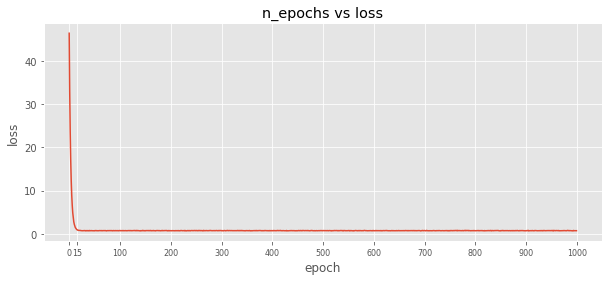

In [70]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 4)
%matplotlib inline

xx = list(map(lambda x: x[0], est3.history))
yy = list(map(lambda x: x[1], est3.history))
plt.plot(xx, yy)
plt.xticks(list(range(0, 1100, 100)) + [15], fontsize=8)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('n_epochs vs loss');

Увеличение значения ```n_epochs``` не очень улучшает результат, поэтому подберем ещё раз гиперпараметры (особенно поскольку была изменена предобработка данных). Посмотрим на среднее ```mean_test_score``` каждого из прошлых значений гиперпараметров и выберем новые значения исходя из этих данных.

In [97]:
cv_res1 = pd.DataFrame(clf.cv_results_)

In [98]:
cv_res1.groupby('param_alpha')['mean_test_score'].mean()

param_alpha
0.0001      0.311891
0.0010      0.219598
0.0100      0.084332
1.0000      0.046526
10.0000     0.045324
100.0000    0.045236
Name: mean_test_score, dtype: float64

In [99]:
cv_res1.groupby('param_batch_size')['mean_test_score'].mean()

param_batch_size
20     0.124359
50     0.127217
100    0.131339
300    0.129589
500    0.114919
Name: mean_test_score, dtype: float64

In [100]:
cv_res1.groupby('param_learning_rate')['mean_test_score'].mean()

param_learning_rate
0.001     0.049741
0.010     0.051232
1.000     0.108579
5.000     0.165812
10.000    0.180676
15.000    0.196868
Name: mean_test_score, dtype: float64

In [ ]:
est4 = LogisticRegressionEstimator(learning_rate=15, n_epochs=15, batch_size=100, alpha=0.0001)

params2 = {'alpha': [0.000001, 0.00001, 0.0001, 0.001],
          'learning_rate': [5, 10, 15, 20],
          'batch_size': [50, 100, 300]}

clf2 = GridSearchCV(est4, params2, scoring='accuracy', verbose=10, n_jobs=-1, cv=3)
clf2.fit(X_train2, y_train)

In [13]:
clf2.best_score_, clf2.best_params_

(0.78469153261446, {'alpha': 0.0001, 'batch_size': 300, 'learning_rate': 20})

Multinominal:

In [31]:
est5 = LogisticRegressionEstimator(learning_rate=20, n_epochs=15,
                                   batch_size=300, alpha=0.0001)
est5.fit(X_train2, y_train)
print('acc', metrics.accuracy_score(y_test, est5.predict(X_test2)))

acc 0.7440254912373871


OVR:

In [20]:
est6 = LogisticRegressionEstimator(learning_rate=20, n_epochs=15,
                                   batch_size=300, alpha=0.0001, multi_class='ovr')
est6.fit(X_train2, y_train)
print('acc', metrics.accuracy_score(y_test, est6.predict(X_test2)))

acc 0.7567711099309612


Увеличим значение ```n_epochs```:

Multinominal:

In [32]:
est7 = LogisticRegressionEstimator(learning_rate=20, n_epochs=100,
                                   batch_size=300, alpha=0.0001)
est7.fit(X_train2, y_train)
print('acc', metrics.accuracy_score(y_test, est7.predict(X_test2)))

acc 0.8070897503983006


OVR:

In [33]:
est8 = LogisticRegressionEstimator(learning_rate=20, n_epochs=100,
                                   batch_size=300, alpha=0.0001, multi_class='ovr')
est8.fit(X_train2, y_train)
print('acc', metrics.accuracy_score(y_test, est8.predict(X_test2)))

acc 0.8077535847052576


Baseline:

In [256]:
# your baseline
print('acc', metrics.accuracy_score(y_test, est.predict(X_test)))

acc 0.7541157727031333


#### How can we justify using accuracy score for this problem?

Метрика ```accuracy``` считает долю правильных ответов из всех ответов классификатора. Когда классы несбалансированы, то мы можем получить высокое значение ```accuracy```, если просто будем приписывать всем объектам метку класса, который чаще встречается. Однако в нашем случае классы более-менее сбалансированы, поэтому можно использовать ```accuracy```.

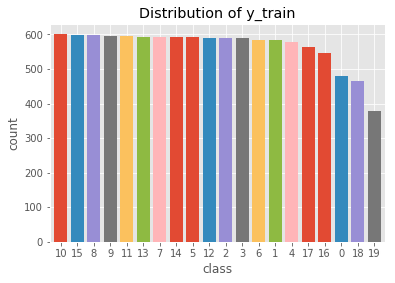

In [25]:
y_train_pd = pd.Series(y_train)
y_train_pd.value_counts().plot.bar(rot=1, width=0.8, title='Distribution of y_train')
plt.xlabel('class')
plt.ylabel('count')
plt.style.use('ggplot')

Text(0, 0.5, 'count')

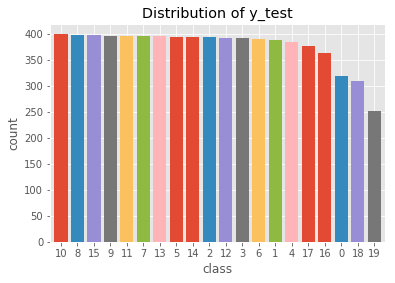

In [26]:
y_test_pd = pd.Series(y_test)
y_test_pd.value_counts().plot.bar(rot=1, width=0.8, title='Distribution of y_test')
plt.xlabel('class')
plt.ylabel('count')

#### What is acuraccy score for random answer for this problem?

Вероятность (при случайном определении класса) правильно определить класс объекта из ```k``` классов составляет $1/k$. В нашем случае количество классов равно 20 (от 0 до 19). Тогда вероятность рандомного ответа для этого случая: $1/20 = 0.05$